# Predicting house prices

Here our target is to predict the houses of an unknown data set

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(rc={'figure.figsize':(20,7)})


import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn import linear_model

In [21]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


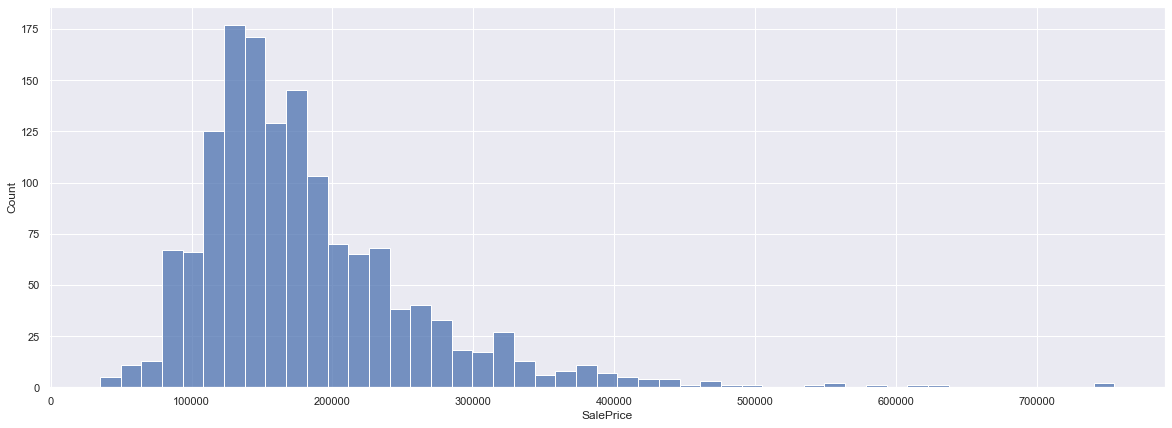

In [3]:
# SalePrice is cleuniquey our target feature that we want to predict
# The distribution is slightly skewed inidcating a log normal distribution
fig, ax = plt.subplots()

sns.histplot(train['SalePrice'], ax=ax, color='b')

plt.show()

<AxesSubplot:>

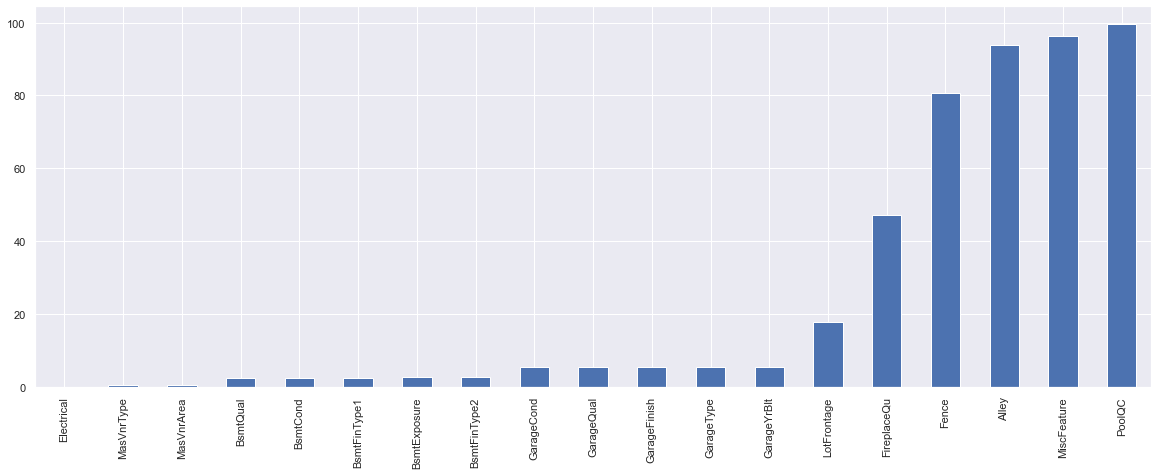

In [4]:
# lets look at all missing data as a percentage
missing = train.isnull().sum()
missing = missing[missing>0]
missing = 100 * missing/len(train)
missing.sort_values(inplace=True)

missing.plot.bar()

In [5]:
# Drop all variables that are missing over 40% of the data 
train = train.drop(labels = missing[missing>40].keys(), axis=1)
test = test.drop(labels = missing[missing>40].keys(), axis=1)

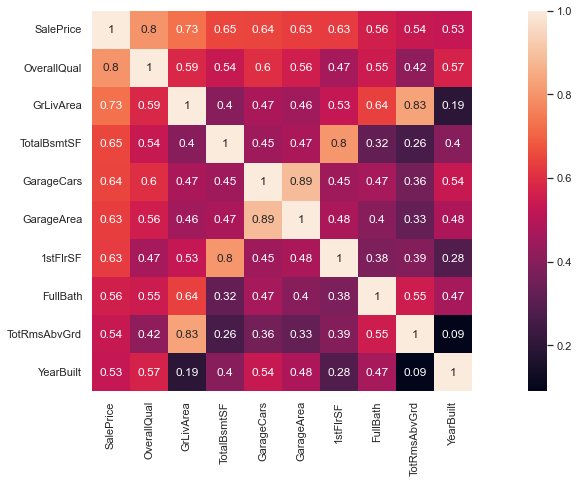

In [37]:
# Let's now look at the correlations between the other independent variables and the target
corrmat = train.corr()

# Sort columns 10 most highly correlated variables
cols = corrmat.nlargest(10, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)

# Create heat maps of correlations of variables with each other 
sns.heatmap(cm, cbar=True, square=True, annot=True, yticklabels=cols.values, xticklabels=cols.values)

plt.show()


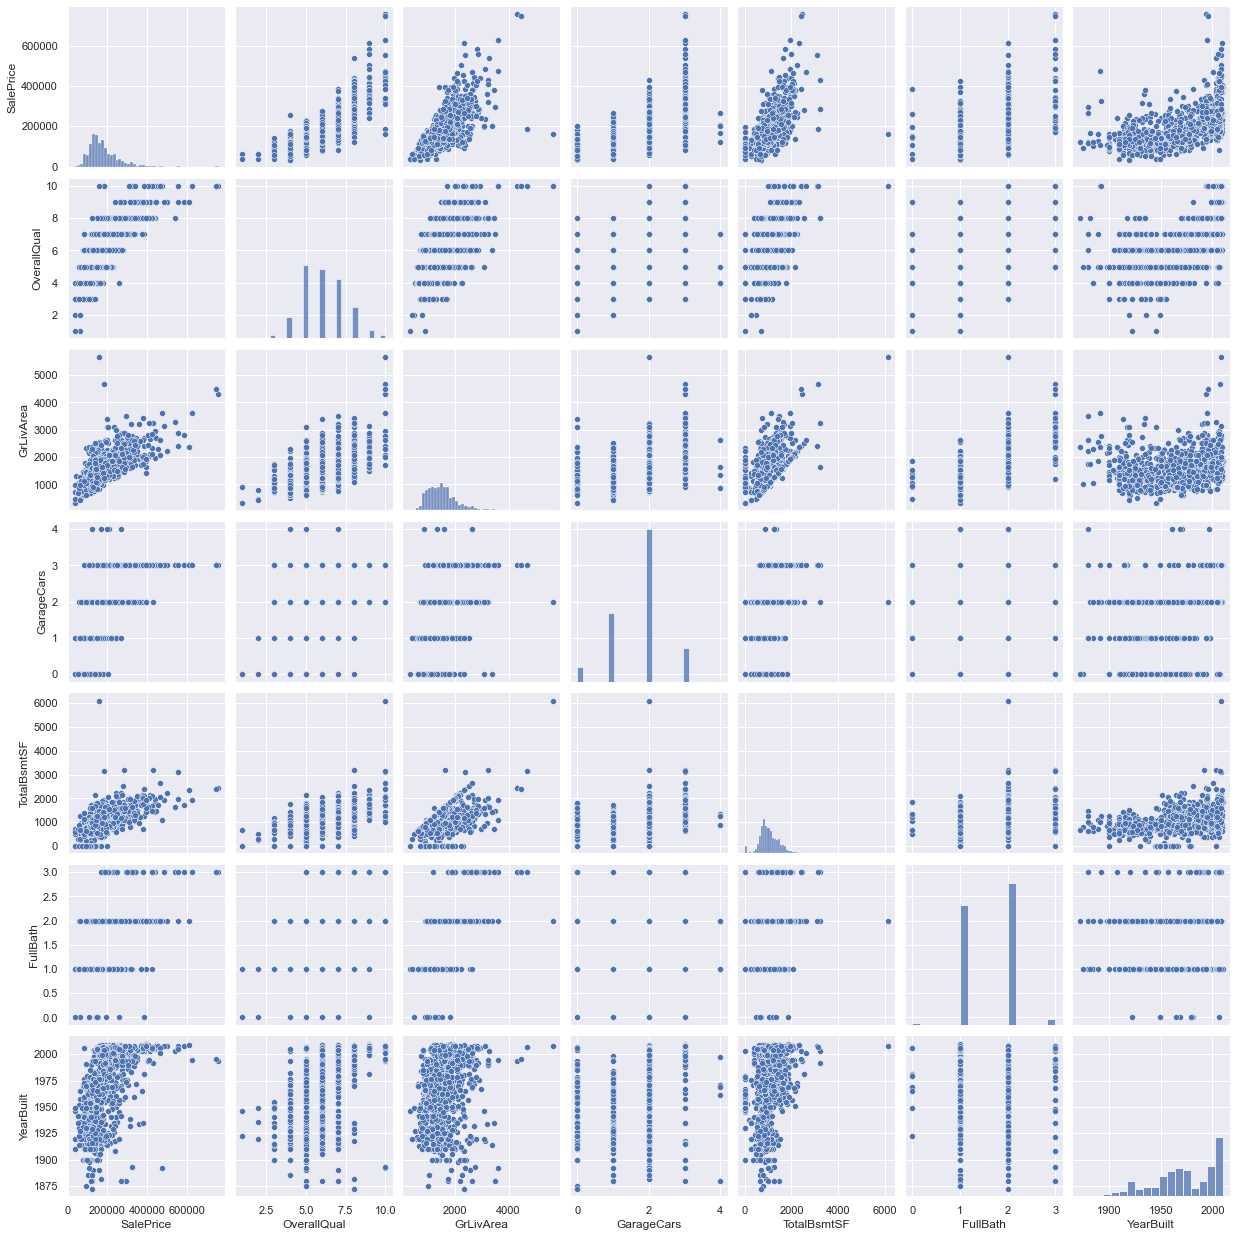

In [23]:
# Clearly GarageCars and GarageArea are highly correlated and so to is TotalBsmtSF
# Is highly correlated with 1stFlrSF so we will not include these

cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols], height = 2.5)

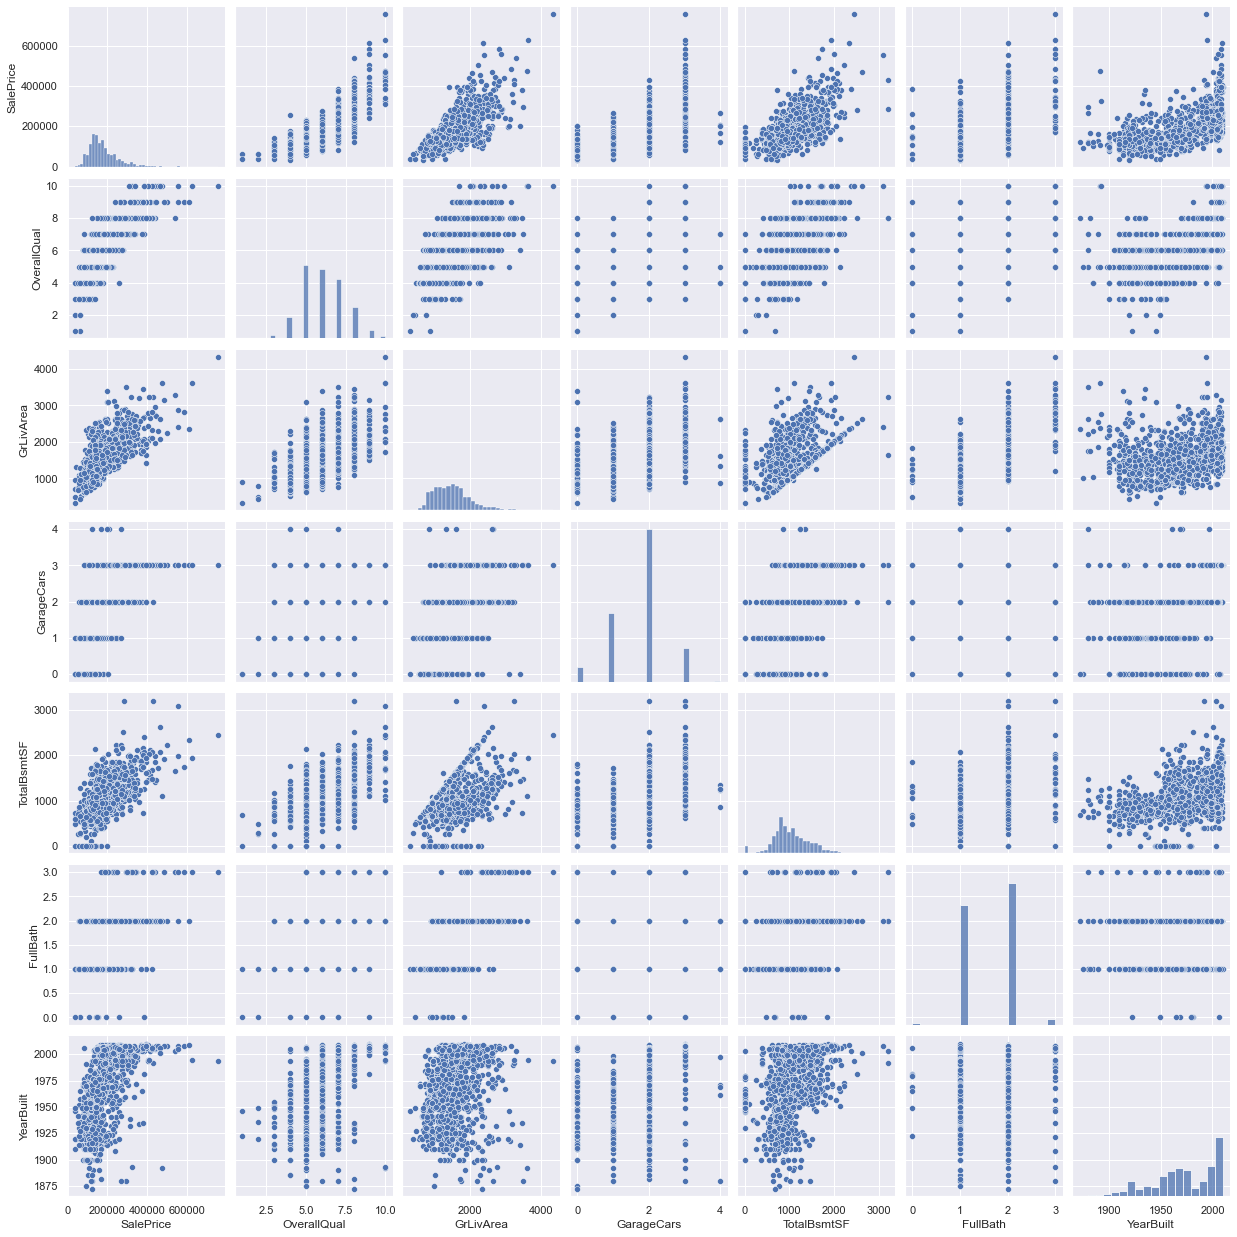

In [24]:
# Drop outlines in the Sales price
train = train[train.GrLivArea <4400]
train = train[train.TotalBsmtSF <4400]

sns.pairplot(train[cols], height=2.5)

In [29]:
# Let's now run Ordinary least squares on this problem but first replace sales price with it's log
# Only include columns used above
X_cols = cols.copy()

X_cols.remove('SalePrice')
train_X = train[X_cols]
train_y = np.log(train['SalePrice'])

# Get test data too
test_X = test[X_cols]

In [30]:
# Check for nulls
test_X.isnull().sum()

OverallQual    0
GrLivArea      0
GarageCars     1
TotalBsmtSF    1
FullBath       0
YearBuilt      0
dtype: int64

In [31]:
# So it doesn't look like there are many with nans, let us just drop these columns
train_X = train_X.fillna(0)
test_X = test_X.fillna(0)

In [32]:
# train on ordinary least squares
model = linear_model.LinearRegression(normalize=True)
model.fit(train_X, train_y)

LinearRegression(normalize=True)

In [33]:
# Lets see how good our model is 
predictedPrice_log = pd.DataFrame(model.predict(train_X), columns=['Predicted Price'])
actualPrice_log = pd.DataFrame(train_y.values, columns=['Actual Price'])  

# Convert back to actual price
actualPrice = np.exp(actualPrice_log)
predictedPrice = np.exp(predictedPrice_log)

df = pd.concat([actualPrice, predictedPrice], axis=1)

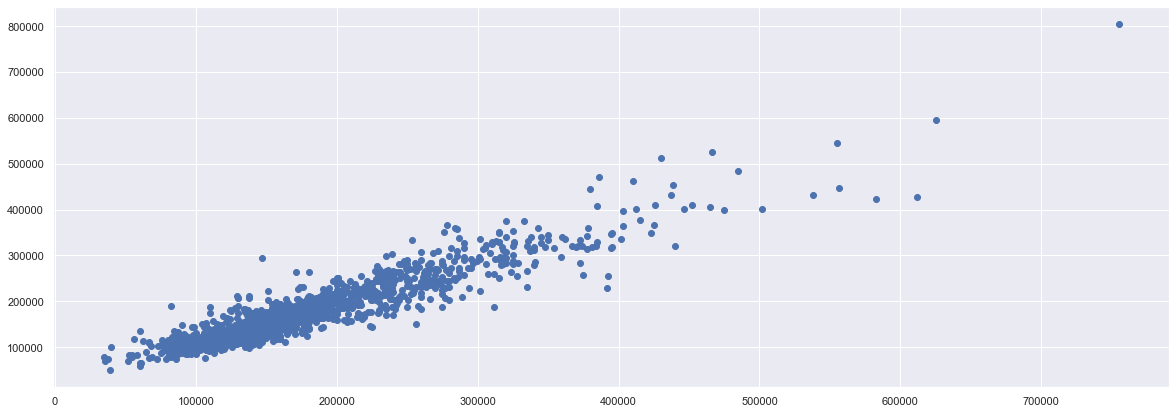

In [34]:
plt.scatter(actualPrice, predictedPrice)

plt.show()

In [35]:
# Now get predicted values
test_y = model.predict(test_X)

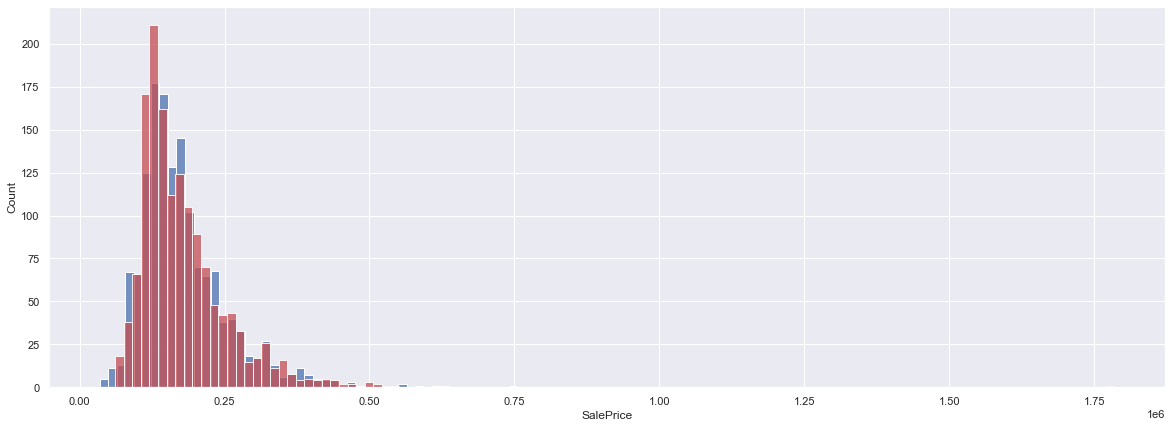

In [36]:
fig, ax = plt.subplots()

sns.histplot(np.exp(train_y), ax=ax, color='b')
sns.histplot(np.exp(test_y), ax=ax, color='r')

plt.show()